# Fertility Rate Prediction - Feature Engineering

This notebook performs feature engineering on the cleaned dataset to create meaningful predictors for fertility rate modeling.

## Objectives:
1. Handle missing data
2. Create temporal features (lag features, rates of change)
3. Create interaction features
4. Create geographical/regional features
5. Feature selection
6. Prepare final dataset for modeling

In [173]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
import warnings

# Configure visualizations
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [174]:
# Load the cleaned dataset
df = pd.read_csv('../data/clean/final_merged_dataset_cleaned.csv')

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

Dataset loaded successfully!

Dataset shape: (13888, 15)

Columns: ['Country Name', 'Country Code', 'Year', 'Female share of employment in senior and middle management (%)', 'Maternal mortality ratio (per 100,000 live births)', 'Labor force participation rate, female (%)', 'advanced_education_pct', 'basic_education_pct', 'Fertility rate', 'Urban population over total population', 'Capital GDP in USD', 'Access to electricity (% of population)', 'WagedFemale', 'InfantMortality', 'LifeExpectancy']


In [175]:
# Quick overview
print("Missing data summary:")
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Pct': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Pct', ascending=False)
print(missing_summary[missing_summary['Missing_Pct'] > 0])

Missing data summary:
                                                                                               Column  \
Female share of employment in senior and middle...  Female share of employment in senior and middl...   
advanced_education_pct                                                         advanced_education_pct   
basic_education_pct                                                               basic_education_pct   
Labor force participation rate, female (%)                 Labor force participation rate, female (%)   
WagedFemale                                                                               WagedFemale   
Access to electricity (% of population)                       Access to electricity (% of population)   
Maternal mortality ratio (per 100,000 live births)  Maternal mortality ratio (per 100,000 live bir...   
InfantMortality                                                                       InfantMortality   
Capital GDP in USD               

## 2. Handle Missing Data

Strategy:
- Drop features with >50% missing data (more conservative threshold)
- Use forward fill for time-series features (within each country)
- Use KNN imputation for remaining features (considers similar countries)

In [176]:
# Identify columns to drop (>50% missing - more conservative threshold)
missing_pct = (df.isnull().sum() / len(df) * 100)
cols_to_drop = missing_pct[missing_pct > 50].index.tolist()

print(f"Columns to drop (>50% missing): {cols_to_drop}")
print(f"Number of columns to drop: {len(cols_to_drop)}")

# Show what we're keeping
cols_kept = [col for col in df.columns if col not in cols_to_drop]
print(f"\nColumns kept:")
for col in cols_kept:
    if col in missing_pct.index:
        print(f"  - {col}: {missing_pct[col]:.2f}% missing")

# Create working dataframe
df_work = df.drop(columns=cols_to_drop).copy()
print(f"\nNew shape after dropping high-missing columns: {df_work.shape}")

Columns to drop (>50% missing): ['Female share of employment in senior and middle management (%)', 'Labor force participation rate, female (%)', 'advanced_education_pct', 'basic_education_pct', 'Access to electricity (% of population)', 'WagedFemale']
Number of columns to drop: 6

Columns kept:
  - Country Name: 0.00% missing
  - Country Code: 0.00% missing
  - Year: 0.00% missing
  - Maternal mortality ratio (per 100,000 live births): 45.52% missing
  - Fertility rate: 0.23% missing
  - Urban population over total population: 0.92% missing
  - Capital GDP in USD: 18.16% missing
  - InfantMortality: 21.73% missing
  - LifeExpectancy: 6.76% missing

New shape after dropping high-missing columns: (13888, 9)


In [177]:
# Remove rows without fertility rate (our target)
df_work = df_work[df_work['Fertility rate'].notna()].copy()
print(f"Shape after removing rows without target: {df_work.shape}")

Shape after removing rows without target: (13856, 9)


In [178]:
# Sort by country and year for time-series operations
df_work = df_work.sort_values(['Country Name', 'Year']).reset_index(drop=True)
print("Data sorted by Country and Year")

Data sorted by Country and Year


In [179]:
# Apply forward fill within each country for time-series continuity
numeric_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
# Exclude Year and target from forward fill
cols_to_fill = [col for col in numeric_cols if col not in ['Year', 'Fertility rate']]

print(f"Applying forward fill within countries for {len(cols_to_fill)} features...")
df_work[cols_to_fill] = df_work.groupby('Country Name')[cols_to_fill].fillna(method='ffill')

# Check remaining missing values
print("\nMissing values after forward fill:")
missing_after_ffill = df_work[cols_to_fill].isnull().sum()
print(missing_after_ffill[missing_after_ffill > 0])

Applying forward fill within countries for 5 features...

Missing values after forward fill:
Maternal mortality ratio (per 100,000 live births)    6295
Urban population over total population                 128
Capital GDP in USD                                    2433
InfantMortality                                       3002
LifeExpectancy                                         897
dtype: int64


In [180]:
# For remaining missing values, use KNN imputation
# KNN considers similar countries based on other features
print("Applying KNN imputation for remaining missing values...")
print(f"Missing values before KNN imputation:")
missing_before = df_work[cols_to_fill].isnull().sum()
print(missing_before[missing_before > 0])

# Apply KNN imputation (n_neighbors=5 means use 5 most similar countries)
# Only impute on numeric columns
imputer = KNNImputer(n_neighbors=5, weights='distance')
df_work[cols_to_fill] = imputer.fit_transform(df_work[cols_to_fill])

print(f"\nTotal missing values after KNN imputation: {df_work.isnull().sum().sum()}")
print("KNN imputation complete - values filled based on similar countries")

Applying KNN imputation for remaining missing values...
Missing values before KNN imputation:
Maternal mortality ratio (per 100,000 live births)    6295
Urban population over total population                 128
Capital GDP in USD                                    2433
InfantMortality                                       3002
LifeExpectancy                                         897
dtype: int64

Total missing values after KNN imputation: 0
KNN imputation complete - values filled based on similar countries


## 3. Create Lag Features

Create features from previous years to capture temporal dependencies

In [181]:
# Features to create lags for (most important predictors from EDA)
# Only create lags for features that still exist after dropping high-missing columns
lag_features = [
    'InfantMortality',
    'LifeExpectancy',
    'Urban population over total population',
    'Maternal mortality ratio (per 100,000 live births)',
    'Capital GDP in USD'
]

# Create only 3-year lags (lag1 removed to reduce multicollinearity)
# lag3 provides temporal information with less redundancy
lags = [3]

print("Creating lag features...")
for feature in lag_features:
    if feature in df_work.columns:
        for lag in lags:
            lag_col_name = f"{feature}_lag{lag}"
            df_work[lag_col_name] = df_work.groupby('Country Name')[feature].shift(lag)
            print(f"  - Created: {lag_col_name}")
    else:
        print(f"  - Skipped {feature} (not in dataset)")

print(f"\nNew shape after adding lag features: {df_work.shape}")

Creating lag features...
  - Created: InfantMortality_lag3
  - Created: LifeExpectancy_lag3
  - Created: Urban population over total population_lag3
  - Created: Maternal mortality ratio (per 100,000 live births)_lag3
  - Created: Capital GDP in USD_lag3

New shape after adding lag features: (13856, 14)


## 4. Create Rate of Change Features

Calculate year-over-year changes to capture trends

In [182]:
# Create rate of change features (percent change from previous year)
print("Creating rate of change features...")

for feature in lag_features:
    if feature in df_work.columns:
        change_col_name = f"{feature}_pct_change"
        df_work[change_col_name] = df_work.groupby('Country Name')[feature].pct_change() * 100
        print(f"  - Created: {change_col_name}")
    else:
        print(f"  - Skipped {feature} (not in dataset)")

print(f"\nNew shape after adding rate of change features: {df_work.shape}")

Creating rate of change features...
  - Created: InfantMortality_pct_change
  - Created: LifeExpectancy_pct_change
  - Created: Urban population over total population_pct_change
  - Created: Maternal mortality ratio (per 100,000 live births)_pct_change
  - Created: Capital GDP in USD_pct_change

New shape after adding rate of change features: (13856, 19)


## 5. Create Interaction Features

Create meaningful combinations of features

In [183]:
# Create interaction features based on domain knowledge
print("Creating interaction features...")

# Healthcare quality index (combination of life expectancy and infant mortality)
# Normalize both to 0-1 scale first
if 'LifeExpectancy' in df_work.columns and 'InfantMortality' in df_work.columns:
    life_exp_norm = (df_work['LifeExpectancy'] - df_work['LifeExpectancy'].min()) / \
                    (df_work['LifeExpectancy'].max() - df_work['LifeExpectancy'].min())
    infant_mort_norm = 1 - (df_work['InfantMortality'] - df_work['InfantMortality'].min()) / \
                       (df_work['InfantMortality'].max() - df_work['InfantMortality'].min())
    df_work['HealthcareQuality_Index'] = (life_exp_norm + infant_mort_norm) / 2
    print("  - Created: HealthcareQuality_Index")

# Urbanization-GDP interaction
if 'Urban population over total population' in df_work.columns and 'Capital GDP in USD' in df_work.columns:
    df_work['Urban_GDP_Interaction'] = df_work['Urban population over total population'] * \
                                        np.log1p(df_work['Capital GDP in USD'])
    print("  - Created: Urban_GDP_Interaction")

# Note: Economic Development Index and Women Empowerment Index were removed 
# because they depend on features dropped due to >50% missing data
# (Access to electricity, WagedFemale, Labor force participation)

print(f"\nNew shape after adding interaction features: {df_work.shape}")

Creating interaction features...
  - Created: HealthcareQuality_Index
  - Created: Urban_GDP_Interaction

New shape after adding interaction features: (13856, 21)


## 6. Create Categorical Features

Add categorical features for better model performance

In [184]:
# Create time-based features
print("Creating time-based categorical features...")

# Decade
df_work['Decade'] = (df_work['Year'] // 10 * 10).astype(int)
print(f"  - Created: Decade ({df_work['Decade'].nunique()} unique values)")

# Era (broader time periods)
def assign_era(year):
    if year < 1980:
        return '1960-1979'
    elif year < 2000:
        return '1980-1999'
    elif year < 2020:
        return '2000-2019'
    else:
        return '2020+'

df_work['Era'] = df_work['Year'].apply(assign_era)
print(f"  - Created: Era ({df_work['Era'].nunique()} unique values)")

print(f"\nNew shape: {df_work.shape}")

Creating time-based categorical features...
  - Created: Decade (7 unique values)
  - Created: Era (4 unique values)

New shape: (13856, 23)


In [185]:
# Create development level categories based on GDP
print("Creating development level categories...")

if 'Capital GDP in USD' in df_work.columns:
    def assign_development_level(gdp):
        if pd.isna(gdp):
            return 'Unknown'
        elif gdp < 1000:
            return 'Low Income'
        elif gdp < 4000:
            return 'Lower Middle Income'
        elif gdp < 12000:
            return 'Upper Middle Income'
        else:
            return 'High Income'
    
    df_work['Development_Level'] = df_work['Capital GDP in USD'].apply(assign_development_level)
    print(f"  - Created: Development_Level")
    print(f"    Distribution: {df_work['Development_Level'].value_counts().to_dict()}")

Creating development level categories...
  - Created: Development_Level
    Distribution: {'Low Income': 5157, 'Lower Middle Income': 3773, 'High Income': 2706, 'Upper Middle Income': 2220}


## 7. Clean Up and Prepare Final Dataset

In [186]:
# Remove rows with NaN values created by lag/diff operations
print(f"Shape before removing NaN rows: {df_work.shape}")
df_final = df_work.dropna().copy()
print(f"Shape after removing NaN rows: {df_final.shape}")
print(f"Rows removed: {len(df_work) - len(df_final)}")

Shape before removing NaN rows: (13856, 24)
Shape after removing NaN rows: (13205, 24)
Rows removed: 651


In [187]:
# Display final feature list
print("\nFinal Feature List:")
print("="*80)
feature_categories = {
    'Identifier': ['Country Name', 'Country Code', 'Year'],
    'Target': ['Fertility rate'],
    'Original Features': [col for col in df_final.columns if col in df.columns and 
                          col not in ['Country Name', 'Country Code', 'Year', 'Fertility rate']],
    'Lag Features': [col for col in df_final.columns if '_lag' in col],
    'Rate of Change': [col for col in df_final.columns if '_pct_change' in col],
    'Interaction Features': [col for col in df_final.columns if '_Index' in col or '_Interaction' in col],
    'Categorical Features': ['Decade', 'Era', 'Development_Level']
}

for category, features in feature_categories.items():
    if features:
        print(f"\n{category} ({len(features)} features):")
        for feat in features:
            if feat in df_final.columns:
                print(f"  - {feat}")


Final Feature List:

Identifier (3 features):
  - Country Name
  - Country Code
  - Year

Target (1 features):
  - Fertility rate

Original Features (5 features):
  - Maternal mortality ratio (per 100,000 live births)
  - Urban population over total population
  - Capital GDP in USD
  - InfantMortality
  - LifeExpectancy

Lag Features (5 features):
  - InfantMortality_lag3
  - LifeExpectancy_lag3
  - Urban population over total population_lag3
  - Maternal mortality ratio (per 100,000 live births)_lag3
  - Capital GDP in USD_lag3

Rate of Change (5 features):
  - InfantMortality_pct_change
  - LifeExpectancy_pct_change
  - Urban population over total population_pct_change
  - Maternal mortality ratio (per 100,000 live births)_pct_change
  - Capital GDP in USD_pct_change

Interaction Features (2 features):
  - HealthcareQuality_Index
  - Urban_GDP_Interaction

Categorical Features (3 features):
  - Decade
  - Era
  - Development_Level


In [188]:
# Summary statistics
print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)
print(f"Original dataset shape: {df.shape}")
print(f"Final dataset shape: {df_final.shape}")
print(f"Total features: {df_final.shape[1]}")
print(f"Total observations: {df_final.shape[0]:,}")
print(f"Missing values: {df_final.isnull().sum().sum()}")
print(f"\nDate range: {df_final['Year'].min():.0f} - {df_final['Year'].max():.0f}")
print(f"Countries: {df_final['Country Name'].nunique()}")


FEATURE ENGINEERING SUMMARY
Original dataset shape: (13888, 15)
Final dataset shape: (13205, 24)
Total features: 24
Total observations: 13,205
Missing values: 0

Date range: 1963 - 2023
Countries: 217


## 8. Correlation Analysis of New Features

In [189]:
# Check correlation of new features with target
numeric_features = df_final.select_dtypes(include=[np.number]).columns.tolist()
# Remove identifiers
numeric_features = [col for col in numeric_features if col not in ['Year']]

# Calculate correlations with fertility rate
correlations = df_final[numeric_features].corr()['Fertility rate'].sort_values(ascending=False)

print("Top 15 Features Correlated with Fertility Rate:")
print("="*80)
print(correlations.head(15))

print("\nBottom 15 Features Correlated with Fertility Rate:")
print("="*80)
print(correlations.tail(15))

Top 15 Features Correlated with Fertility Rate:
Fertility rate                                                   1.000
InfantMortality_lag3                                             0.796
InfantMortality                                                  0.787
Maternal mortality ratio (per 100,000 live births)_lag3          0.606
Maternal mortality ratio (per 100,000 live births)               0.593
Urban population over total population_pct_change                0.178
LifeExpectancy_pct_change                                        0.080
Maternal mortality ratio (per 100,000 live births)_pct_change    0.021
Capital GDP in USD_pct_change                                    0.020
InfantMortality_pct_change                                       0.018
Capital GDP in USD_lag3                                         -0.400
Capital GDP in USD                                              -0.410
Decade                                                          -0.458
Urban population over total p

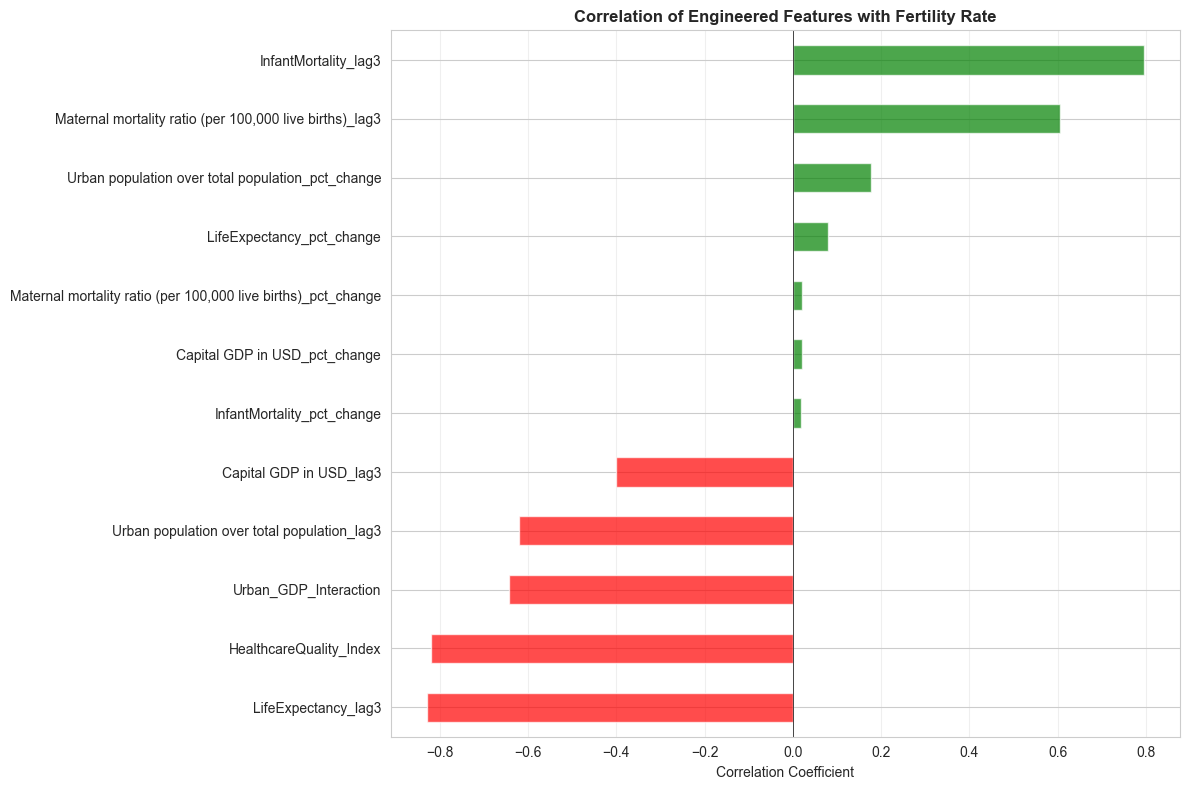

In [190]:
# Visualize correlations of new features
new_features = [col for col in df_final.columns if any(x in col for x in 
                ['_lag', '_pct_change', '_Index', '_Interaction'])]
new_features = [col for col in new_features if col in numeric_features]

if new_features:
    new_feature_corr = correlations[new_features].sort_values()
    
    plt.figure(figsize=(12, max(8, len(new_features) * 0.3)))
    colors = ['red' if x < 0 else 'green' for x in new_feature_corr.values]
    new_feature_corr.plot(kind='barh', color=colors, alpha=0.7)
    plt.xlabel('Correlation Coefficient')
    plt.title('Correlation of Engineered Features with Fertility Rate', fontsize=12, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Save Engineered Dataset

In [191]:
# Save the engineered dataset
output_path = '../data/clean/fertility_rate_engineered_features.csv'
df_final.to_csv(output_path, index=False)
print(f"Engineered dataset saved to: {output_path}")
print(f"Shape: {df_final.shape}")
print(f"\nReady for model building!")

Engineered dataset saved to: ../data/clean/fertility_rate_engineered_features.csv
Shape: (13205, 24)

Ready for model building!


In [192]:
# Display sample of final dataset
print("\nSample of final dataset:")
df_final.head(10)


Sample of final dataset:


,Country Name,Country Code,Year,"Maternal mortality ratio (per 100,000 live births)",Fertility rate,Urban population over total population,Capital GDP in USD,InfantMortality,LifeExpectancy,InfantMortality_lag3,LifeExpectancy_lag3,Urban population over total population_lag3,"Maternal mortality ratio (per 100,000 live births)_lag3",Capital GDP in USD_lag3,InfantMortality_pct_change,LifeExpectancy_pct_change,Urban population over total population_pct_change,"Maternal mortality ratio (per 100,000 live births)_pct_change",Capital GDP in USD_pct_change,HealthcareQuality_Index,Urban_GDP_Interaction,Decade,Era,Development_Level
3,Afghanistan,AFG,1963.000,2440.545,7.302,9.276,156.233,242.500,34.201,251.200,32.799,8.401,1839.168,156.574,-1.182,1.315,3.342,11.230,-0.082,0.120,46.915,1960,1960-1979,Low Income
4,Afghanistan,AFG,1964.000,2716.075,7.304,9.586,156.120,239.700,34.673,248.400,33.291,8.684,1989.743,156.481,-1.155,1.380,3.342,11.290,-0.073,0.129,48.476,1960,1960-1979,Low Income
5,Afghanistan,AFG,1965.000,2966.901,7.305,9.904,156.078,236.900,35.124,245.400,33.757,8.976,2194.152,156.361,-1.168,1.301,3.317,9.235,-0.026,0.138,50.082,1960,1960-1979,Low Income
6,Afghanistan,AFG,1966.000,3032.996,7.320,10.233,156.112,234.200,35.583,242.500,34.201,9.276,2440.545,156.233,-1.140,1.307,3.322,2.228,0.022,0.147,51.748,1960,1960-1979,Low Income
7,Afghanistan,AFG,1967.000,2819.647,7.339,10.570,156.194,231.400,36.042,239.700,34.673,9.586,2716.075,156.120,-1.196,1.290,3.293,-7.034,0.052,0.156,53.458,1960,1960-1979,Low Income
8,Afghanistan,AFG,1968.000,2453.752,7.363,10.918,191.006,228.600,36.510,236.900,35.124,9.904,2966.901,156.078,-1.210,1.298,3.292,-12.977,22.288,0.165,57.402,1960,1960-1979,Low Income
9,Afghanistan,AFG,1969.000,2095.994,7.389,11.275,217.281,225.800,36.979,234.200,35.583,10.233,3032.996,156.112,-1.225,1.285,3.270,-14.580,13.756,0.175,60.725,1960,1960-1979,Low Income
10,Afghanistan,AFG,1970.000,2839.737,7.400,11.643,267.894,223.100,37.460,231.400,36.042,10.570,2819.647,156.194,-1.196,1.301,3.264,35.484,23.294,0.184,65.135,1970,1960-1979,Low Income
11,Afghanistan,AFG,1971.000,1644.069,7.432,12.021,314.943,220.200,37.932,228.600,36.510,10.918,2453.752,191.006,-1.300,1.260,3.247,-42.105,17.562,0.193,69.188,1970,1960-1979,Low Income
12,Afghanistan,AFG,1972.000,1851.222,7.453,12.410,316.253,217.100,38.423,225.800,36.979,11.275,2095.994,217.281,-1.408,1.294,3.236,12.600,0.416,0.203,71.478,1970,1960-1979,Low Income


In [193]:
# Show data types
print("\nData types:")
print(df_final.dtypes)


Data types:
Country Name                                                      object
Country Code                                                      object
Year                                                             float64
Maternal mortality ratio (per 100,000 live births)               float64
Fertility rate                                                   float64
Urban population over total population                           float64
Capital GDP in USD                                               float64
InfantMortality                                                  float64
LifeExpectancy                                                   float64
InfantMortality_lag3                                             float64
LifeExpectancy_lag3                                              float64
Urban population over total population_lag3                      float64
Maternal mortality ratio (per 100,000 live births)_lag3          float64
Capital GDP in USD_lag3               